## 1. Import Libraries

In [35]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

## 2. Merge all trip_metrics

In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
trips_merged = pd.concat(df_list)
# trips_merged.to_csv('trips_merged.csv',index=False)



In [38]:
# # if you have all data just use this method
# trips_merged = pd.read_csv("../Yeni dosyalar/trips_merged.csv")
# trips_merged

## 3. Feature Enginnering

In [39]:
trips_merged = trips_merged.rename(columns={"City_Name": "State_Name"})

In [40]:
trips_merged.isna().sum()

ID                                0
Energy_Consumption_kWh            0
Start_Time                        0
End_Time                          0
Duration_s                        0
Average_Speed_kmh                 0
Total_Distance_km               667
State_Name                      776
Max_Speed                       667
Min_Speed                       667
Positive_Acceleration_Mean     4995
Positive_Acceleration_Sum         0
Positive_Altitude-diff_Mean    4601
Positive_Altitude-diff_Sum        0
Max_Altitude-diff               709
Min_Altitude-diff               709
Max_Altitude                    691
Min_Altitude                    691
GPS_Altitude_Mean               691
Average_Ambient_Temperature      41
Average_air                    2307
Characteristic_Acceleration    3053
Kinetic_Intensity              4441
Traffic_Category_Mean             0
dtype: int64

In [41]:
trips_merged['Start_Time'] = pd.to_datetime(trips_merged['Start_Time'])
trips_merged['End_Time'] = pd.to_datetime(trips_merged['End_Time'])

trips_merged['Start_Hour'] = trips_merged['Start_Time'].dt.hour
trips_merged['End_Hour'] = trips_merged['End_Time'].dt.hour

In [42]:
## handling the energy consumption values by dropping rows with value 0 and takinbg absolute value to remove negative consumptions
trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})
# trips_merged = trips_merged[trips_merged['Energy_Consumption_kWh/km'] !=0]
# trips_merged['Energy_Consumption_kWh/km'] = trips_merged['Energy_Consumption_kWh/km'].abs()

In [43]:
state_dict = ['内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana','Naâma ⵏⵄⴰⵎⴰ النعامة',
              'Castilla-La Mancha', 'Aragón', '河南省', 'Centre-Val de Loire','Occitanie', 'Salzburg', None, 'Kansas', 'Nevada','Colorado']
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Nebraska', 'Indiana', 'Missouri',
       'California', 'Washington', 'Arizona', 'Maryland',
       'District of Columbia', 'New Jersey', 'Illinois', 'Michigan',
       'Wisconsin', 'Virginia'], dtype=object)

## 4. Splitting the data to train test

In [44]:
trips_merged = trips_merged.dropna()

In [45]:
cols_to_keep = ['Duration_s', 'Average_Speed_kmh', 'Max_Speed','Start_Hour','End_Hour',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude',
       'Min_Altitude', 'GPS_Altitude_Mean', 'Average_Ambient_Temperature',
       'Average_air', 'Kinetic_Intensity', 'Traffic_Category_Mean',
       'State_Name','Total_Distance_km']

In [46]:
X = trips_merged[cols_to_keep]
y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Name'])

In [47]:
trips_merged

,ID,Energy_Consumption_kWh/km,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,State_Name,Max_Speed,Min_Speed,...,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,Start_Hour,End_Hour
0,vehicle_106_2013-01-02_trip_1,3.533599,2013-01-02 17:03:03,2013-01-02 23:01:16,21493,2.360999,14.095821,New York,85.29502,0.0,...,186.0,0.0,31.439192,-1.630595,2543.015725,0.008343,0.000067,1.987904,17,23
2,vehicle_106_2013-01-02_trip_3,1.070359,2013-01-03 04:38:03,2013-01-03 06:59:37,8494,7.062909,16.664542,New York,48.28020,0.0,...,59.0,0.0,16.777634,1.608240,2530.378340,0.006475,0.000172,2.689935,4,6
3,vehicle_106_2013-01-03_trip_1,1.515306,2013-01-03 07:00:39,2013-01-03 08:30:55,5416,5.218145,7.850409,New York,64.37360,0.0,...,92.0,2.0,43.463725,1.625696,2532.115193,-0.057436,-0.000621,3.000000,7,8
4,vehicle_106_2013-01-03_trip_2,33.204084,2013-01-03 09:24:15,2013-01-03 09:26:51,156,0.102506,0.004442,New York,3.21868,0.0,...,29.0,25.0,26.573248,2.235669,2495.414013,-2.206256,-9.538746,3.000000,9,9
5,vehicle_106_2013-01-03_trip_3,1.348663,2013-01-03 12:55:46,2013-01-03 14:33:13,5847,9.185457,14.918713,New York,62.76426,0.0,...,154.0,0.0,41.387996,-0.426129,2551.754104,0.003700,0.000033,2.000000,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12072,vehicle_441_2014-12-17_trip_5,0.936321,2014-12-17 20:27:55,2014-12-17 20:32:17,262,12.990984,0.945455,New Jersey,40.23350,0.0,...,51.0,30.0,35.444867,7.000000,6.000000,-0.103654,-0.001678,1.000000,20,20
12073,vehicle_441_2014-12-17_trip_6,0.975793,2014-12-17 20:51:37,2014-12-17 20:53:50,133,7.302080,0.269771,New Jersey,16.09340,0.0,...,54.0,32.0,36.895522,7.074627,6.000000,-0.691696,-0.083466,1.000000,20,20
12074,vehicle_441_2014-12-17_trip_7,0.317572,2014-12-17 22:02:23,2014-12-17 23:08:04,2636,38.616836,28.276106,New Jersey,53.10822,0.0,...,52.0,5.0,20.529389,9.943496,6.000000,0.000555,0.000003,1.000000,22,23
12075,vehicle_441_2014-12-17_trip_8,0.820847,2014-12-17 23:43:54,2014-12-17 23:57:43,829,29.226002,6.730099,New Jersey,69.20162,0.0,...,56.0,3.0,23.185542,11.306024,6.000000,0.004368,0.000022,1.000000,23,23


## Explatory Data Analysis

In [48]:
#merging energy consumption to another df to visualzie the train data better. This df_train will not be used in models
df_train = X_train.copy()
df_train['Energy_Consumption_kWh/km'] = y_train

<Axes: >

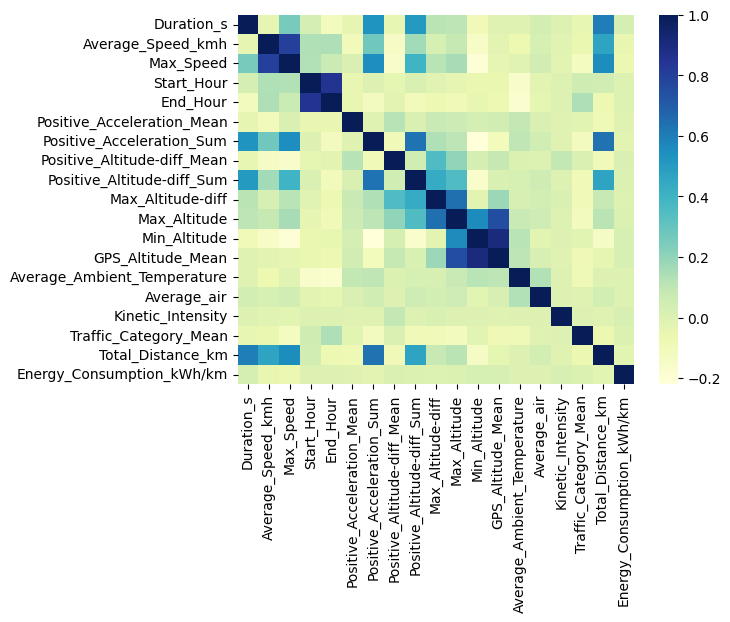

In [49]:
sns.heatmap(df_train.drop(columns=["State_Name"]).corr(), cmap="YlGnBu")

<Axes: >

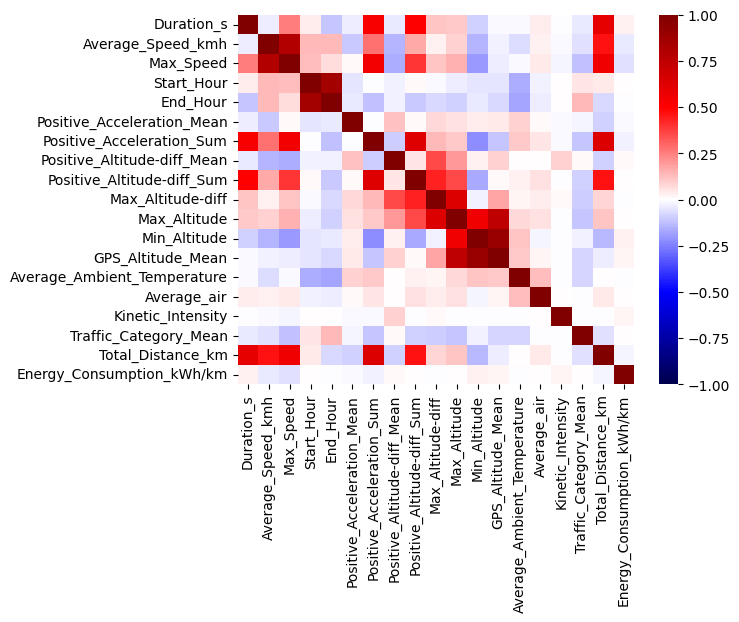

In [50]:
vmin = -1
vmax = 1
cmap = sns.color_palette(["red", "white", "green"])
sns.heatmap(df_train.drop(columns=["State_Name"]).corr(), cmap = "seismic" ,center=0,  fmt=".1f", vmin=vmin, vmax=vmax,)

In [51]:
df_train.drop(columns=['State_Name']).corr()


,Duration_s,Average_Speed_kmh,Max_Speed,Start_Hour,End_Hour,Positive_Acceleration_Mean,Positive_Acceleration_Sum,Positive_Altitude-diff_Mean,Positive_Altitude-diff_Sum,Max_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Kinetic_Intensity,Traffic_Category_Mean,Total_Distance_km,Energy_Consumption_kWh/km
Duration_s,1.000000,-0.036417,0.255309,0.036230,-0.115495,-0.035027,0.529793,-0.043690,0.504613,0.109701,0.107532,-0.091784,-0.010852,-0.008182,0.037250,-0.003770,-0.042566,0.597147,0.027496
Average_Speed_kmh,-0.036417,1.000000,0.802223,0.135473,0.138346,-0.105014,0.277331,-0.143059,0.164662,0.026145,0.086252,-0.144559,-0.026468,-0.063771,0.027039,-0.014955,-0.057994,0.462048,-0.046294
Max_Speed,0.255309,0.802223,1.000000,0.129489,0.068690,0.012746,0.547870,-0.161693,0.395205,0.113996,0.155523,-0.202256,-0.035754,-0.014942,0.044972,-0.020656,-0.122273,0.556148,-0.059009
Start_Hour,0.036230,0.135473,0.129489,1.000000,0.856503,-0.047467,-0.004461,-0.030910,0.011630,-0.014600,-0.035477,-0.052585,-0.052648,-0.161661,-0.028198,0.000452,0.053888,0.042448,0.001964
End_Hour,-0.115495,0.138346,0.068690,0.856503,1.000000,-0.046114,-0.118892,-0.025282,-0.104114,-0.071205,-0.093435,-0.044226,-0.070579,-0.175225,-0.032615,0.001503,0.140070,-0.070524,-0.002945
Positive_Acceleration_Mean,-0.035027,-0.105014,0.012746,-0.047467,-0.046114,1.000000,-0.006823,0.121636,0.011324,0.075889,0.061358,0.034102,0.041639,0.090334,0.009021,-0.008006,-0.020504,-0.086951,-0.010841
Positive_Acceleration_Sum,0.529793,0.277331,0.547870,-0.004461,-0.118892,-0.006823,1.000000,-0.095021,0.629574,0.135909,0.107651,-0.220780,-0.110556,0.102992,0.048917,-0.008922,-0.116666,0.633001,-0.026884
Positive_Altitude-diff_Mean,-0.043690,-0.143059,-0.161693,-0.030910,-0.025282,0.121636,-0.095021,1.000000,0.049360,0.353804,0.199973,0.028234,0.086857,0.004219,0.002256,0.093002,0.010692,-0.092295,0.010251
Positive_Altitude-diff_Sum,0.504613,0.164662,0.395205,0.011630,-0.104114,0.011324,0.629574,0.049360,1.000000,0.434512,0.351685,-0.167399,0.014694,0.025733,0.058480,-0.002068,-0.090322,0.462193,0.007675
Max_Altitude-diff,0.109701,0.026145,0.113996,-0.014600,-0.071205,0.075889,0.135909,0.353804,0.434512,1.000000,0.638393,-0.025386,0.178900,0.022133,0.038358,0.015413,-0.094949,0.083530,-0.005241


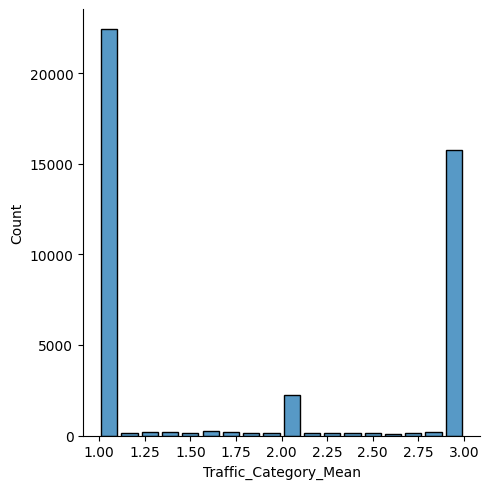

In [52]:
sns.displot(df_train, x="Traffic_Category_Mean", shrink=.8)

In [53]:
df_train.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed', 'Start_Hour',
       'End_Hour', 'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'State_Name',
       'Total_Distance_km', 'Energy_Consumption_kWh/km'],
      dtype='object')

 ## 5. BaseLine Classifier

In [54]:
#This part was not in the feature engineering part as we have to startify our train test split according to city names so this part should come after that
X_train = pd.get_dummies(X_train, columns=['State_Name'], prefix="",prefix_sep="") 
X_test = pd.get_dummies(X_test, columns=['State_Name'], prefix="",prefix_sep="") 

In [55]:
def custom_metric(actual_values,predictions):
    if(actual_values == 0):
        return 0
    error = abs(predictions - actual_values) / actual_values
    if error <= 0.1:
        return 1
    else:
        return 0

In [56]:
consumption_mean = y_train.mean()

df_temp = pd.DataFrame(y)
df_temp['baseline'] = consumption_mean
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['baseline']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Baseline Accuracy is:',accuracy)

Baseline Accuracy is: 0.009018448527485687


In [57]:
X_train

,Duration_s,Average_Speed_kmh,Max_Speed,Start_Hour,End_Hour,Positive_Acceleration_Mean,Positive_Acceleration_Sum,Positive_Altitude-diff_Mean,Positive_Altitude-diff_Sum,Max_Altitude-diff,...,Maryland,Michigan,Missouri,Nebraska,New Jersey,New York,Unknown,Virginia,Washington,Wisconsin
6808,57,4.951815,12.87472,7,7,0.687752,8.940778,1.444444,13.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1417,1864,15.148375,43.45218,8,8,0.879051,418.428400,1.116000,279.0,8.0,...,0,0,0,0,0,0,0,0,0,0
7875,1349,33.153596,86.90436,18,19,0.634795,190.438567,1.084746,256.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3682,10279,55.859283,67.59228,15,18,0.545716,163.169194,1.009709,104.0,2.0,...,0,0,0,0,0,0,0,0,0,0
8973,1173,21.838497,64.37360,0,1,0.647290,205.190850,1.352941,322.0,29.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9803,636,24.198208,61.15492,0,1,0.596052,75.102533,1.301887,138.0,29.0,...,0,0,0,0,0,0,0,0,1,0
2587,834,1.214233,51.49888,11,11,2.235194,51.409472,2.397260,175.0,53.0,...,0,0,0,0,0,1,0,0,0,0
9891,1430,16.448782,57.93624,22,22,0.552225,140.817250,1.095238,161.0,8.0,...,0,0,0,0,1,0,0,0,0,0
7276,332,16.504192,64.37360,16,16,0.596052,60.797289,1.027027,38.0,2.0,...,0,0,0,0,1,0,0,0,0,0


In [58]:
X_test.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed', 'Start_Hour',
       'End_Hour', 'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'Total_Distance_km',
       'Arizona', 'California', 'District of Columbia', 'Illinois', 'Indiana',
       'Maryland', 'Michigan', 'Missouri', 'Nebraska', 'New Jersey',
       'New York', 'Unknown', 'Virginia', 'Washington', 'Wisconsin'],
      dtype='object')

## 6. Applying Machine Learning Models

### 6.1 Random Forest

In [59]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
clf = RandomForestRegressor(n_estimators=500)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(mse)


14965.039252370292


In [60]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.5686623012160898


### 6.2 XGBoost

In [62]:
mse = make_scorer(mean_squared_error)
params = {
    'max_depth': [9],
    'subsample':[0.9],
    'colsample_bytree':[0.9],
    'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = XGBRegressor(

  
)

# searching the model
XGB_Model= GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)


In [63]:
XGB_Model.fit(X_train, y_train)
predictions = XGB_Model.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
4.110580495442007


In [64]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.4890551917680075


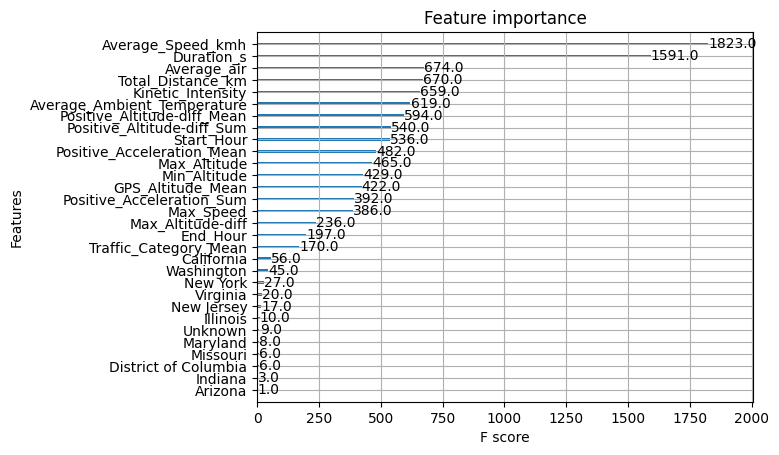

In [65]:
from xgboost import plot_importance
plot_importance(XGB_Model.best_estimator_)
plt.show()

### 6.3 Extra Trees

In [66]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
clf = ExtraTreesRegressor()
parameters = {
    'n_estimators': [50],
    'max_depth': [34],
    'min_samples_split': [ 21]
}
clf = GridSearchCV(clf, parameters, cv=5, verbose=True, scoring=mse)
clf.fit(X_train, y_train)
clf.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 34, 'min_samples_split': 21, 'n_estimators': 50}

In [67]:
predictions = clf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(mse)


18182.45800880876


In [68]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['Energy_Consumption_kWh/km'],row['predictions']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print('Accuracy is:',accuracy)

Accuracy is: 0.5626753975678204
